In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from collections import Counter

In [ ]:
#df = pd.read_table("../data/Aminer/AP_train.tsv", sep = "\t+", index_col = 0, engine = 'python')
#save to pickle for faster loading in future
#df.to_pickle("../data/Aminer/AP_train.pickle")

In [2]:
df = pd.read_pickle("../data/Aminer/AP_train.pickle")

In [6]:
df.head(20).tail(10)

,title,authors,year,venue,refs,abs
index,,,,,,
11,Lower Bounds and Fast Algorithms for Sequence ...,George M. Trojan,1984.0,Journal of the ACM (JACM),NaN,NaN
12,Space-Time Trade-Offs for Banded Matrix Problems,John E. Savage,1984.0,Journal of the ACM (JACM),"289024,408638,600828,688897",NaN
13,The VLSI Complexity of Selected Graph Problems,Joseph Já Já,1984.0,Journal of the ACM (JACM),"769,289452,319821,408343,598672,598673,598675,...",NaN
14,Computability with Pascal,John S. Mallozzi;Nicholas J. De Lillo,1984.0,Computability with Pascal,NaN,NaN
15,Ambiguity and decision problems concerning num...,"Karel Culik, II;Arto Salomaa",1984.0,Information and Control,NaN,NaN
16,The implication problem for functional and inc...,John C. Mitchell,1984.0,Information and Control,NaN,NaN
17,Cynamic parallel memories,Uzi Vishkin;Avi Wigderson,1984.0,Information and Control,NaN,NaN
18,Succinct representations of graphs,Hana Galperin;Avi Wigderson,1984.0,Information and Control,NaN,NaN
19,On storage media with after effects,H. S. Witsenhausen;A. D. Wyner,1984.0,Information and Control,NaN,NaN


In [7]:
n_rows = df.shape[0]
n_rows

1976815

# 1a

In [8]:
authors = [author.split(';') for author in df[df['authors'].notnull()]['authors']]
n_authors = len(set([name for author in authors for name in author]))
n_venues = len(set(df['venue']))
n_pubs = df[['title', 'authors', 'year', 'venue']].drop_duplicates().shape[0]
references = [ref.split(',') for ref in df[df['refs'].notnull()]['refs']]
n_refs = len(set([ref for reference in references for ref in reference]))
print("Total distinct authors:\t", n_authors)
print("Total distinct venues:\t", n_venues)
print("Total publications:\t", n_pubs)
print("Total citations:\t", n_refs) # total | distinct

Total distinct authors:	 1483290
Total distinct venues:	 255808
Total publications:	 1964961
Total citations:	 871089


# 1b

In [5]:
venue_not_null = df[df['venue'].notnull()]
venue_not_null[venue_not_null['venue'].str.contains('Principles and Practice of Knowledge Discovery in Databases')]

,title,authors,year,venue,refs,abs
index,,,,,,
799597,Summarization of dynamic content in web collec...,Adam Jatowt;Mitsuru Ishizuka,2004.0,PKDD '04 Proceedings of the 8th European Confe...,"168251,207272,217578,272249,287616,357908,4117...",This paper describes a new research proposal o...
799734,Proceedings of the 8th European Conference on ...,Jean-François Boulicaut;Floriana Esposito;Fosc...,2004.0,PKDD '04 Proceedings of the 8th European Confe...,NaN,NaN
799735,Random matrices in data analysis,Dimitris Achlioptas,2004.0,PKDD '04 Proceedings of the 8th European Confe...,NaN,We show how carefully crafted random matrices ...
799736,Data privacy,Rakesh Agrawal,2004.0,PKDD '04 Proceedings of the 8th European Confe...,NaN,There is increasing need to build information ...
799737,Breaking through the syntax barrier: searching...,Soumen Chakrabarti,2004.0,PKDD '04 Proceedings of the 8th European Confe...,NaN,The next wave in search technology will be dri...
799738,Real-world learning with Markov logic networks,Pedro Domingos,2004.0,PKDD '04 Proceedings of the 8th European Confe...,NaN,Machine learning and data mining systems have ...
799739,Strength in diversity: the advance of data ana...,David J. Hand,2004.0,PKDD '04 Proceedings of the 8th European Confe...,NaN,The scientific analysis of data is only around...
799740,Mining positive and negative association rules...,Maria-Luiza Antonie;Osmar R. Zaïane,2004.0,PKDD '04 Proceedings of the 8th European Confe...,NaN,Typical association rules consider only items ...
799741,An experiment on knowledge discovery in chemic...,Sandra Berasaluce;Claude Laurenço;Amedeosw Nap...,2004.0,PKDD '04 Proceedings of the 8th European Confe...,NaN,"In this paper, we present an experiment on kno..."


The venue has multiple entries, based on the year.

# 1c

In [6]:
batch_size = 10000

In [7]:
def count_authors(batch):
    global auth_counter
    for author in batch.str.split(';', expand=True).stack().values:
        auth_counter[author] += 1

In [9]:
auth_counter = Counter()
for i in tqdm(range(n_rows//batch_size + 1)):
    start_index = batch_size * i
    end_index = batch_size * (i + 1)
    count_authors(df['authors'][start_index:end_index])

100%|██████████| 198/198 [00:16<00:00, 12.22it/s]


In [10]:
len(auth_counter) # matches number of authors

1483290

In [11]:
counts = np.array(list(auth_counter.values()))

Text(0.5,1,'Publication per Author')

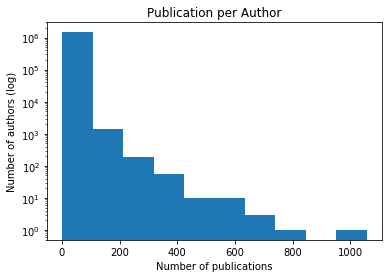

In [12]:
plt.yscale('log', nonposy='clip')
plt.hist(counts)
plt.xlabel('Number of publications')
plt.ylabel('Number of authors (log)')
plt.title('Publication per Author')

# 1d

In [13]:
def print_summary(values, string):
    print(string, ": ", sep='')
    print("Mean: ", np.mean(values), sep="\t\t\t")
    print("1st quantile: ", np.percentile(values, 25), sep="\t\t")
    print("Median/2nd quantile: ", np.median(values), sep="\t")
    print("3st quantile: ", np.percentile(values, 75), sep="\t\t")
    print("Standard deviation: ", np.std(values), sep="\t")

In [14]:
print_summary(counts, "Number of publications per author:")

Number of publications per author:: 
Mean: 			3.28167586918
1st quantile: 		1.0
Median/2nd quantile: 	1.0
3st quantile: 		2.0
Standard deviation: 	8.83637959265


The mean is larger than the median. The distribution is left or negative skewed.

# 1e

In [15]:
publication_counts = Counter()

In [16]:
publication_counts = df['venue'].value_counts()

In [17]:
print_summary(publication_counts, "Number of publications pper venue:")

Number of publications pper venue:: 
Mean: 			7.7309658368695855
1st quantile: 		1.0
Median/2nd quantile: 	1.0
3st quantile: 		1.0
Standard deviation: 	83.3809075405714


Text(0.5,1,'Publications per Venue')

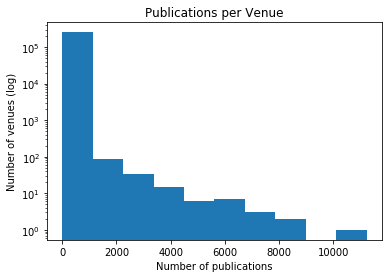

In [18]:
plt.hist(publication_counts)
plt.yscale('log', nonposy='clip')
plt.xlabel('Number of publications')
plt.ylabel('Number of venues (log)')
plt.title('Publications per Venue')

In [19]:
print("Venue with maximum publications: ", publication_counts.idxmax())

Venue with maximum publications:  IEEE Transactions on Information Theory


# 1f 

### Number of references

In [20]:
non_null_refs = df[df['refs'].notnull()]

In [21]:
df['ref_counts'] = non_null_refs['refs'].str.count(',') + 1

Text(0.5,1,'Publications per Reference')

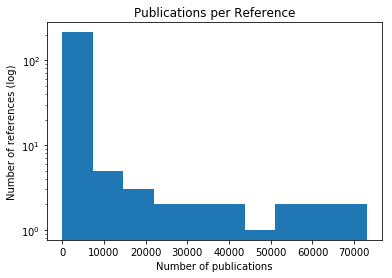

In [22]:
plt.hist(df['ref_counts'].value_counts())
plt.yscale('log', nonposy='clip')
plt.xlabel('Number of publications')
plt.ylabel('Number of references (log)')
plt.title('Publications per Reference')

In [23]:
print("Publication with largest references:")
df.loc[df['ref_counts'].idxmax()]

Publication with largest citations:


title                                          Cited References
authors       Johannes Grabmeier;Erich Kaltofen;Volker Weisp...
year                                                       2003
venue                                 Computer algebra handbook
refs          293,767,858,1363,1460,1807,1825,2172,2593,2835...
abs                                                         NaN
ref_counts                                                  772
Name: 719353, dtype: object

This makes sense, as the paper seems to be just a list of publications

### Number of citations

In [24]:
def count_citations(batch):
    global citation_counter
    for reference in batch.str.split(',', expand=True).stack().values:
        citation_counter[int(reference)] += 1

In [26]:
citation_counter = Counter()
batch_size = 10000
for i in tqdm(range(n_rows//batch_size + 1)):
    start_index = batch_size * i
    end_index = batch_size * (i + 1)
    count_citations(non_null_refs['refs'][start_index:end_index])

100%|██████████| 198/198 [00:28<00:00,  6.88it/s]


In [27]:
print("Publication with the most citations:")
print(df.loc[citation_counter.most_common()[0][0]])

Publication with the most citations:
title         Computers and Intractability: A Guide to the T...
authors                       Michael R. Garey;David S. Johnson
year                                                       1979
venue         Computers and Intractability: A Guide to the T...
refs                                                        NaN
abs                                                         NaN
ref_counts                                                  NaN
Name: 408396, dtype: object


This is a very old paper, 1979, makes sense that it has the most references.

# 1g

In [29]:
def citations_per_venue(batch):
    global citations_per_venue_counter
    for publication in batch['refs'].str.split(',', expand=True).stack().values:
        try:
            citations_per_venue_counter[df.loc[int(publication)]['venue']] += 1
        except IndexError:
            pass
        except KeyError:
            pass
    return

In [31]:
batch_size = 1000
citations_per_venue_counter = Counter()
for i in tqdm(range(n_rows//batch_size + 1)):
    start_index = batch_size * i
    end_index = batch_size * (i + 1)
    citations_per_venue(df[start_index:end_index])

100%|██████████| 1977/1977 [21:05<00:00,  1.56it/s]


In [32]:
len(publication_counts), len(citations_per_venue_counter)

(255685, 84575)

In [33]:
impact = {}
for value in tqdm(citations_per_venue_counter.most_common()):
    if value[0] in publication_counts:
        impact[value[0]] = value[1]/publication_counts[0]

100%|██████████| 84575/84575 [00:01<00:00, 63880.03it/s]


In [34]:
len(impact)

84504

Text(0.5,1,'Publications per Citation')

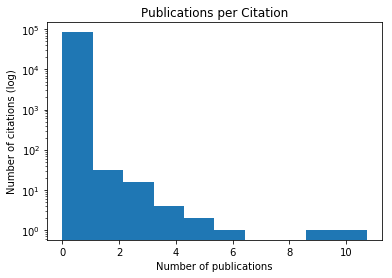

In [35]:
plt.hist(impact.values())
plt.yscale('log', nonposy='clip')
plt.xlabel('Number of publications')
plt.ylabel('Number of citations (log)')
plt.title('Publications per Citation')

# 1h

In [36]:
max_key = max(impact, key=lambda i: impact[i])  # off
print(max_key, "has max impact factor: ", impact[max_key]) 

Communications of the ACM has max impact factor:  10.71826846


The above number is believable

# 1i

In [37]:
impact_10 = {}
sub_publication_count = publication_counts[publication_counts >= 10]
for value in tqdm(citations_per_venue_counter.most_common()):
    if value[0] in sub_publication_count:
        impact_10[value[0]] = value[1]/sub_publication_count[0]

100%|██████████| 84575/84575 [00:00<00:00, 184527.30it/s]


In [38]:
len(sub_publication_count), len(impact_10)

(23458, 22346)

Text(0.5,1,'Publications per Citation')

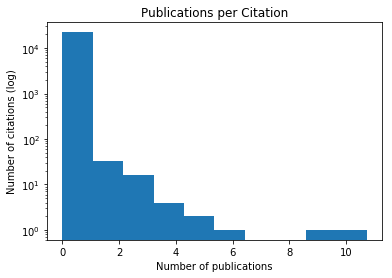

In [39]:
plt.hist(impact_10.values())
plt.yscale('log', nonposy='clip')
plt.xlabel('Number of publications')
plt.ylabel('Number of citations (log)')
plt.title('Publications per Citation')

The distribution has not changed much, although the values for each bins have reduced. Almost every venue has more than ten publications.

In [40]:
index = 1 # off
for key, value in enumerate(impact_10):
    if index > 10:
        break
    print(index, value, " with impact factor: ", impact_10[value])
    index += 1

1 Communications of the ACM  with impact factor:  10.71826846
2 IEEE Transactions on Pattern Analysis and Machine Intelligence  with impact factor:  9.26970695644
3 Journal of the ACM (JACM)  with impact factor:  5.92713993052
4 IEEE Transactions on Computers  with impact factor:  4.44375167008
5 Computer  with impact factor:  4.35753095217
6 IEEE Transactions on Information Theory  with impact factor:  4.08256880734
7 IEEE Transactions on Software Engineering  with impact factor:  4.01532021021
8 Proceedings of the SIGCHI Conference on Human Factors in Computing Systems  with impact factor:  3.59499421039
9 Artificial Intelligence  with impact factor:  3.25501024316
10 Journal of Computational Physics  with impact factor:  3.17110537098


In [41]:
print("Mean: ", np.mean(list(citations_per_venue_counter.values())), sep="\t") 
print("Median: ", np.median(list(citations_per_venue_counter.values())), sep="\t")

Mean: 	85.720070943
Median: 	4.0


The mean is much larger than the median, the distribution is right or positive skewed.

# 1j

Text(0.5,1,'Numeber of references per publication per year')

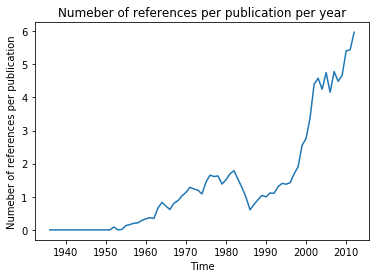

In [42]:
df['ref_counts'].fillna(0, inplace=True)
plt.plot(df[['ref_counts', 'year']].groupby('year').mean())
plt.xlabel('Time')
plt.ylabel('Numeber of references per publication')
plt.title('Numeber of references per publication per year')

In [43]:
df = pd.concat([df, pd.DataFrame.from_dict(citation_counter, orient='index', )], axis=1, join_axes=[df.index])
df.rename(columns={0:'citations'}, inplace=True)
df['citations'].fillna(0, inplace=True)

Text(0.5,1,'Numeber of citations per publication per year')

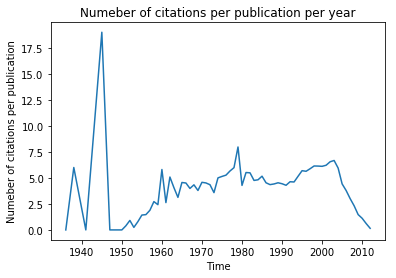

In [44]:
plt.plot(df[['citations', 'year']].groupby('year').mean())
plt.xlabel('Time')
plt.ylabel('Numeber of citations per publication')
plt.title('Numeber of citations per publication per year')